# Imports and Functions

In [ ]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli

# Draw d random bins
def draw_bins(d, bins):
  chosen = [None] * d
  for i in range(d):
    chosen[i] = random.randint(0, bins-1)
  return chosen

# Calculate the Gap
def gap(load, balls, bins):
  max_load = 0
  for bin in range(bins):
    if load[bin] > load[max_load]:
      max_load = bin
  return load[max_load] - balls/bins

# Add a batch of balls
def d_choice(bins, load, d):
  if d > bins:
    raise Exception("Invalid choice")
  chosen = draw_bins(d, bins)
  if d == 1:
    return chosen[0]
  else:
    min_load = chosen[0]
    for i in chosen:
      if load[i] < load[min_load]:
        min_load = i
    min_bins = []
    for i in chosen:
      if i != min_load and load[i] == load[min_load]:
        min_bins.append(i)
    if len(min_bins) == 0:
      return min_load
    else:
      min_bins.append(min_load)
      return min_bins[random.randint(0,len(min_bins) - 1)]

"""
  - Returns **'UPPER_TIE'** if both values are above the ref
  - Returns **'LOWER_TIE'** if both values are below the ref
  - Returns **'A'** if only `values[index_a]` is below `ref`.
  - Returns **'B'** otherwise.

    Parameters
  ----------
  index_a : int
      Index for A in `values`.
  index_b : int
      Index for B in `values`.
  values : list[float]
      List of numeric values.
  ref : float
      Reference value.
"""
def decide_using_reference(index_a, index_b, values, ref):
  if values[index_a] > ref and values[index_b] > ref:
    return "UPPER_TIE"
  elif values[index_a] < ref and values[index_b] < ref:
    return "LOWER_TIE"
  elif values[index_a] < ref:
    return "A"
  else:
    return "B"


"""
  executes the two choices experiment but doesn't pick the smallest loaded bin,
  instead, if k = 1, picks the one below the median (or random if both or none), and if
  k = 2 and both options are on the same side of the median, picks the one below the 25% or 75%
  of the values below the median (or random if both or none)
"""
def two_choice_partial_info(bins, load, k):
  median = np.median(load)
  percentile25 = np.percentile(load, 25)
  percentile75 = np.percentile(load, 75)
  chosen = draw_bins(2, bins)
  median_result = decide_using_reference(chosen[0], chosen[1], load, median)

  if (median_result == "UPPER_TIE" or median_result == "LOWER_TIE") and k == 1:
    return chosen[random.randint(0,1)]

  if median_result == "UPPER_TIE":
    percentile_result = decide_using_reference(chosen[0], chosen[1], load, percentile75)
    if percentile_result == "UPPER_TIE" or percentile_result == "LOWER_TIE":
      return chosen[random.randint(0,1)]
    elif percentile_result == "A":
      return chosen[0]
    else:
      return chosen[1]

  if median_result == "LOWER_TIE":
    percentile_result = decide_using_reference(chosen[0], chosen[1], load, percentile25)
    if percentile_result == "UPPER_TIE" or percentile_result == "LOWER_TIE":
      return chosen[random.randint(0,1)]
    elif percentile_result == "A":
      return chosen[0]
    else:
      return chosen[1]

  elif median_result == "A":
    return chosen[0]
  else:
    return chosen[1]

# Choose strategy based on beta
def beta_choice(bins, beta, load, batch, d):
  old_load = load.copy()
  for _ in range(batch):
    r = bernoulli.rvs(beta, size=1)
    if r == 0:
      load[d_choice(bins, old_load, 1)] += 1
    else:
      load[d_choice(bins, old_load, d)] += 1

# Choose strategy based on beta, using two choice partial info as second option
def beta_choice_partial_info(bins, beta, load, batch, k):
  old_load = load.copy()
  for _ in range(batch):
    r = bernoulli.rvs(beta, size=1)
    if r == 0:
      load[d_choice(bins, old_load, 1)] += 1
    else:
      load[two_choice_partial_info(bins, old_load, k)] += 1

# Run an iteration of an experiment, partial_info = 0 means no usage of partial info, otherwise is the number of questions to ask
def execute_experiment(balls, bins, beta, batch, repeat, d = 2, partial_info=0):
  avg_gap = 0
  for _ in range(repeat):
    load = [0] * bins
    k = balls // batch
    r = balls % batch
    for _ in range(k):
      if partial_info == 0:
        beta_choice(bins, beta, load, batch, d)
      else:
        beta_choice_partial_info(bins, beta, load, batch, partial_info)
    if r > 0:
      if partial_info == 0:
        beta_choice(bins, beta, load, r, d)
      else:
        beta_choice_partial_info(bins, beta, load, r, partial_info)
    avg_gap += gap(load, balls, bins)
  return avg_gap / repeat

# Plot all iterations of an experiment
def show_experiment(bins, x_axis, avg_gap, variants, title, x_label, variant_label, highlight, repeat):
  n = len(variants)
  plt.figure(figsize=(10, 6))
  for i in range(n):
    plt.plot(x_axis, avg_gap[i], label=f'${variant_label} = {variants[i]}$', linestyle='-')
    plt.scatter(highlight[i][0], highlight[i][1], c='red', s=80, zorder=5)
    for h in range(2):
      text_label = f'{highlight[i][1][h]:.2f}'
      plt.annotate(text_label, (highlight[i][0][h], highlight[i][1][h]), textcoords="offset points", xytext=(15, 5), ha='center', fontsize=9, color='black')
  plt.xlabel(x_label)
  plt.ylabel(f'Average Gap $G_n$ (where $T = {repeat}$ repetitions)')
  plt.title(title)

  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

# Run Experiment (batch of 1 ball)

Experiment "$G_n$ vs. Number of Balls" execution took 265.18661693299873 seconds


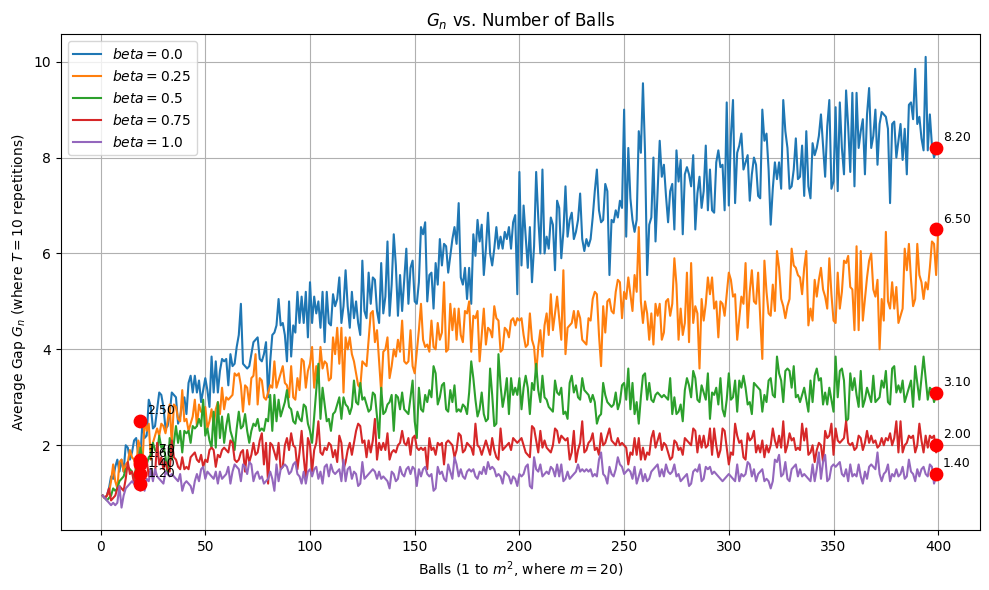

In [ ]:
bins = 20
repeat = 10
m = bins - 1
m2 = bins**2 - 1
avg_gap = [None] * 5
betas = [x for x in range(5)]
balls = np.arange(1, bins**2 + 1)
highlight = [None] * 5
title = '$G_n$ vs. Number of Balls'

start = time.perf_counter()
for beta in betas:
  avg_gap[beta] = []
  for b in balls:
    avg_gap[beta].append(execute_experiment(b, bins, beta * 0.25, 1, repeat))
  highlight[beta] = [[m, m2], [avg_gap[beta][m], avg_gap[beta][m2]]]
end = time.perf_counter()
print(f'Experiment "{title}" execution took {end - start} seconds')

show_experiment(bins, balls, avg_gap, [beta * 0.25 for beta in betas], title, f'Balls (1 to $m^2$, where $m={bins}$)', 'beta', highlight, repeat)

# Run Experiment (batch of b balls)

Experiment "$G_n$ vs. Batch Size" execution took 25.74227081799836 seconds


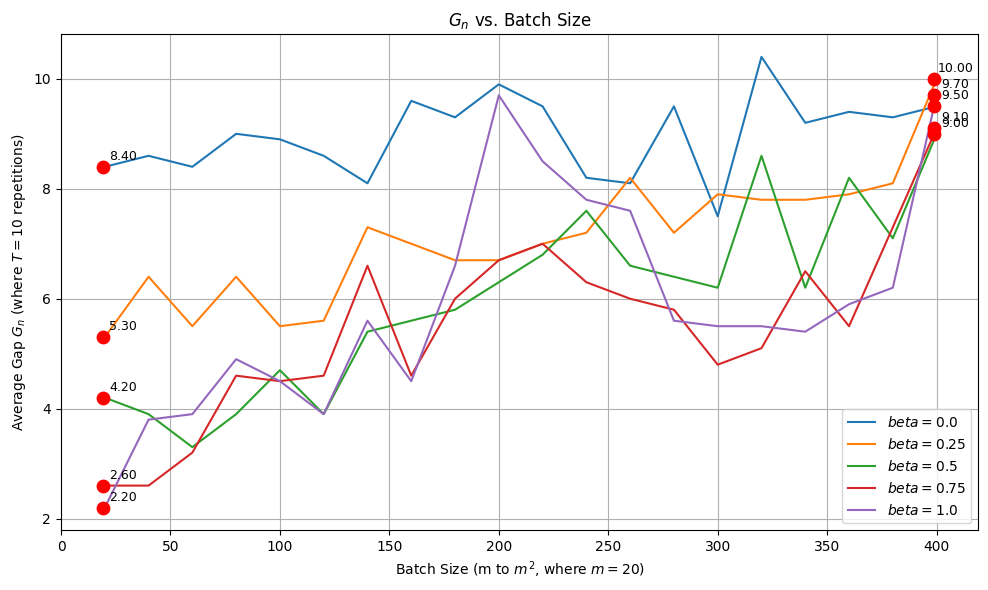

In [ ]:
bins = 20
repeat = 10
m = bins - 1
m2 = bins**2 - 1
avg_gap = [None] * 5
betas = [x for x in range(5)]
batches = [b for b in range(bins, m2 + 2, bins)]
highlight = [None] * 5
title = '$G_n$ vs. Batch Size'

start = time.perf_counter()
for beta in betas:
  avg_gap[beta] = []
  for batch in batches:
    avg_gap[beta].append(execute_experiment(m2 + 1, bins, beta * 0.25, batch, repeat))
  highlight[beta] = [[m, m2], [avg_gap[beta][0], avg_gap[beta][bins - 1]]]
end = time.perf_counter()
print(f'Experiment "{title}" execution took {end - start} seconds')

show_experiment(bins, batches, avg_gap, [beta * 0.25 for beta in betas], title, f'Batch Size (m to $m^2$, where $m={bins}$)', 'beta', highlight, repeat)

# Repeating experiments going from 3 to 6 choices

Experiment "$G_n$ vs. Number of Balls using d = 3" execution took 164.51157740099734 seconds


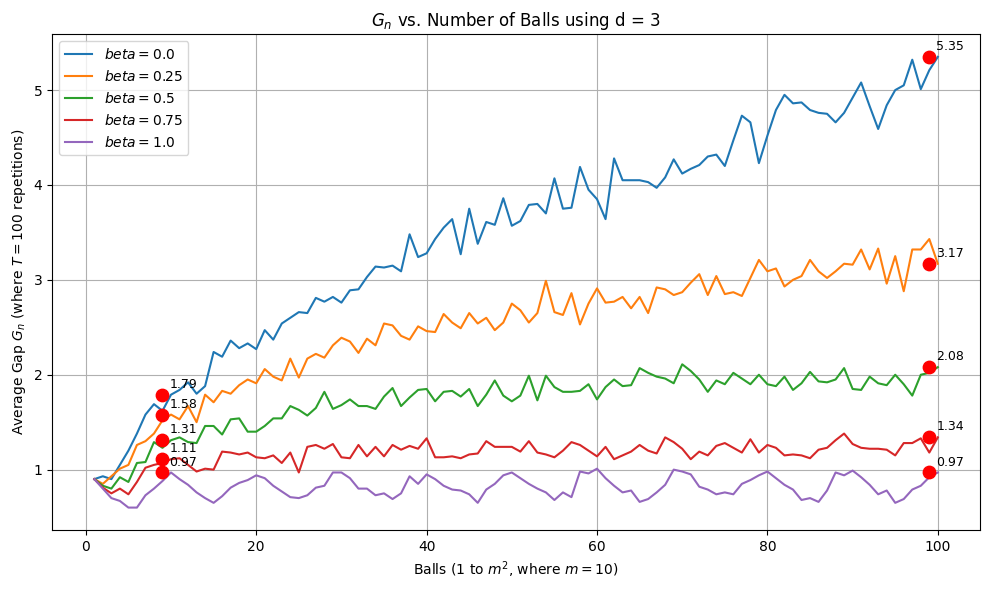

Experiment "$G_n$ vs. Number of Balls using d = 4" execution took 175.9642396140007 seconds


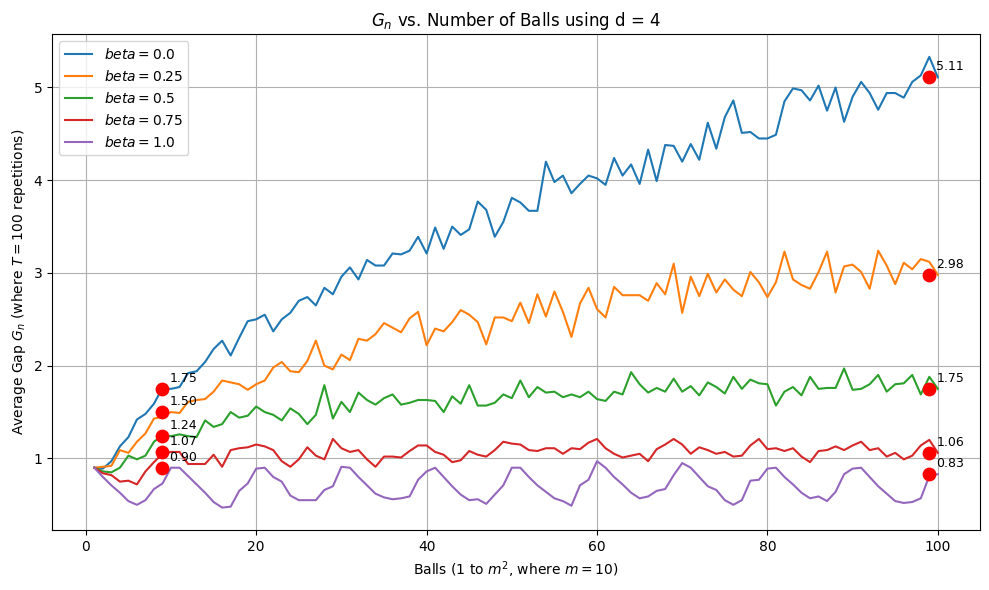

Experiment "$G_n$ vs. Number of Balls using d = 5" execution took 175.67645203899883 seconds


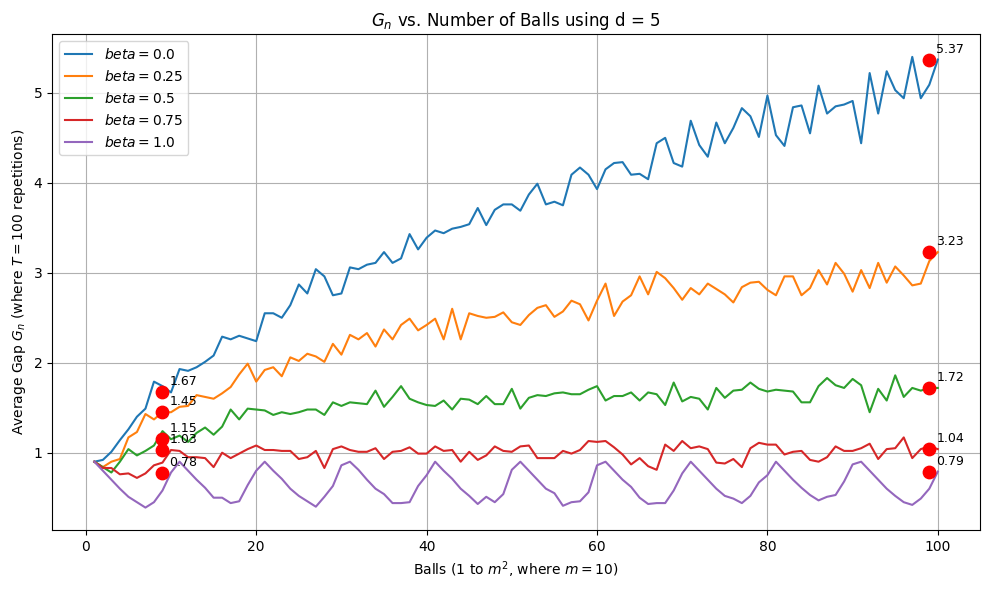

Experiment "$G_n$ vs. Number of Balls using d = 6" execution took 179.58191131100102 seconds


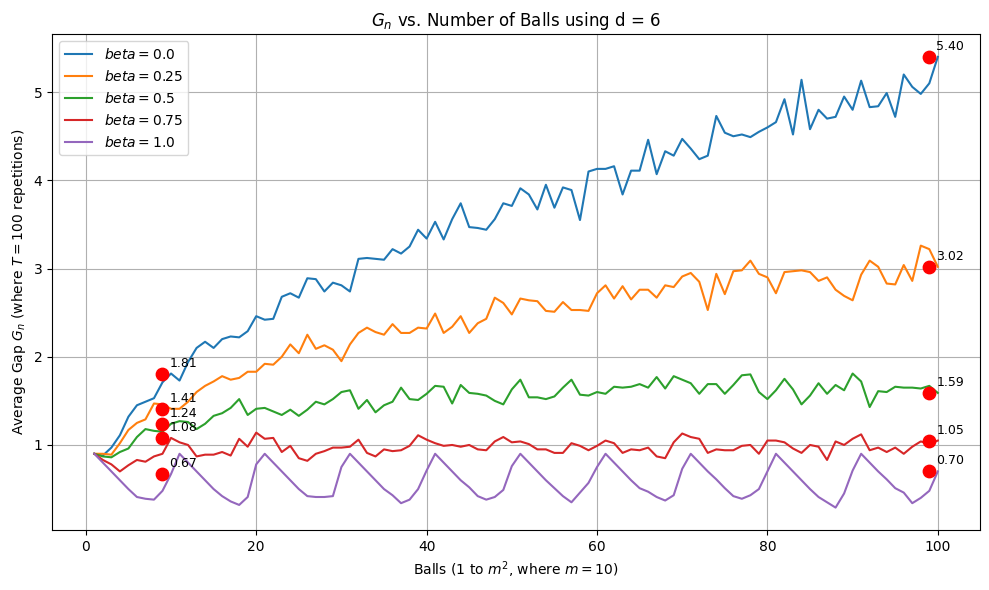

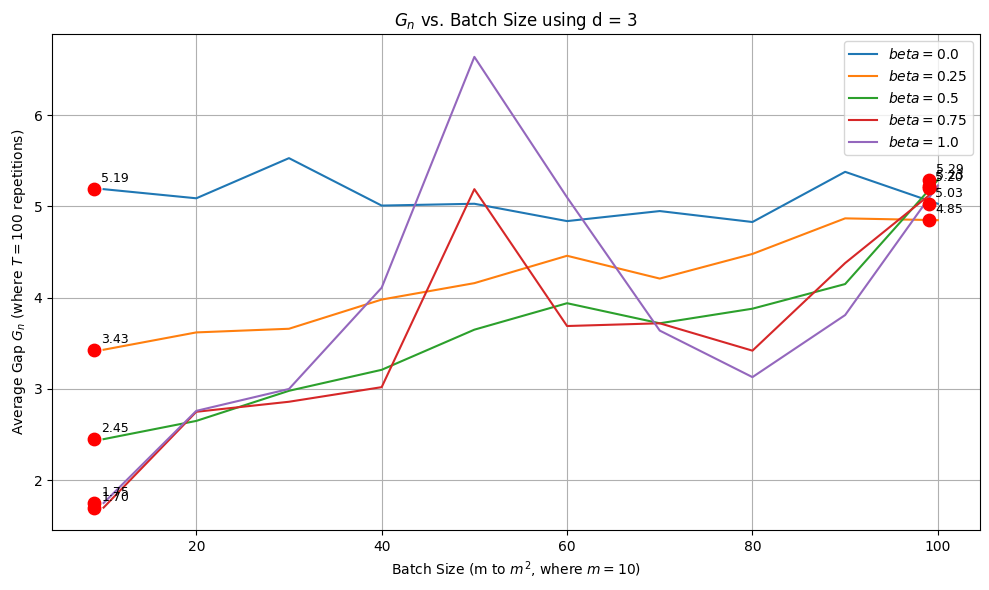

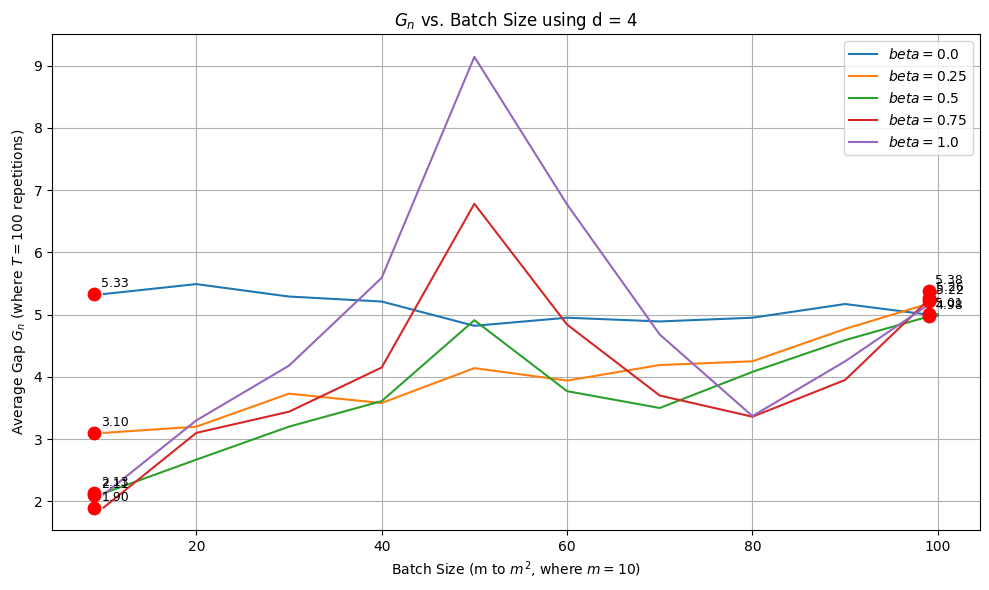

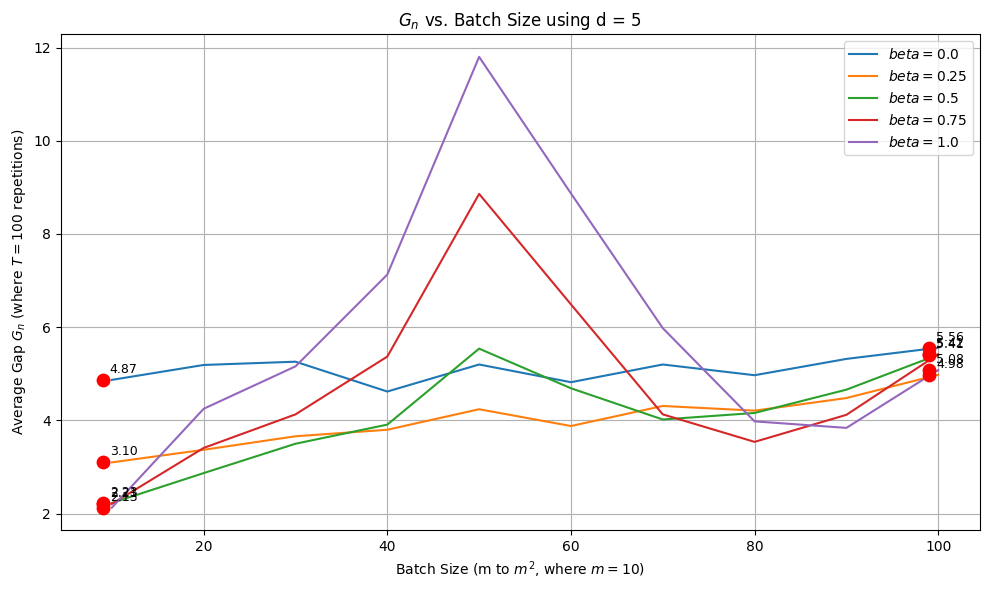

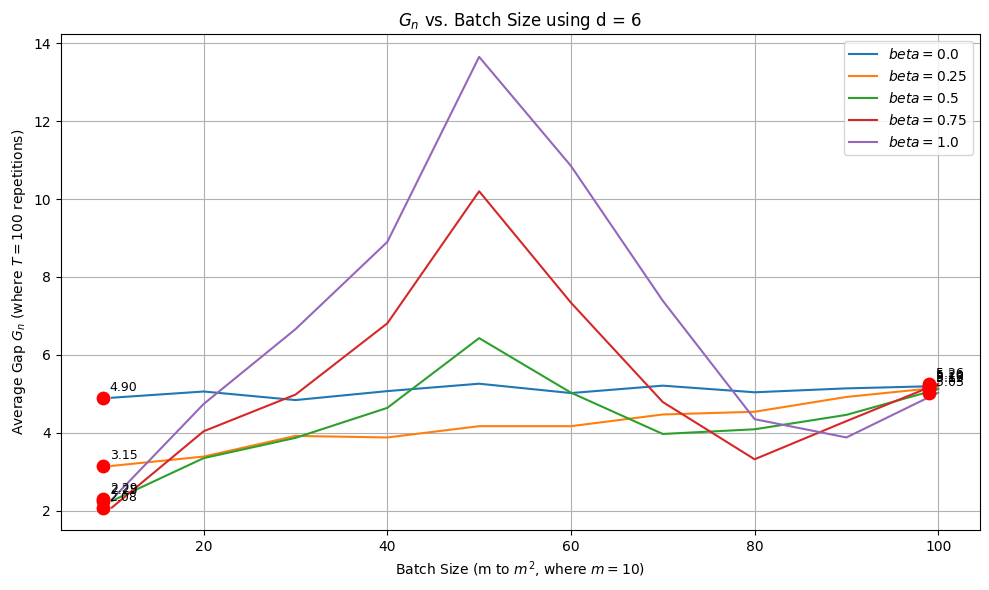

In [ ]:
max_d = 7
min_d = 3

bins = 10
repeat = 100
m = bins - 1
m2 = bins**2 - 1
avg_gap = [None] * 5
betas = [x for x in range(5)]
balls = np.arange(1, bins**2 + 1)
highlight = [None] * 5


for d in range(min_d, max_d):
  title = f'$G_n$ vs. Number of Balls using d = {d}'
  start = time.perf_counter()
  for beta in betas:
    avg_gap[beta] = []
    for b in balls:
      avg_gap[beta].append(execute_experiment(b, bins, beta * 0.25, 1, repeat, d = d))
    highlight[beta] = [[m, m2], [avg_gap[beta][m], avg_gap[beta][m2]]]
  end = time.perf_counter()
  print(f'Experiment "{title}" execution took {end - start} seconds')
  show_experiment(bins, balls, avg_gap, [beta * 0.25 for beta in betas], title, f'Balls (1 to $m^2$, where $m={bins}$)', 'beta', highlight, repeat)

avg_gap = [None] * 5
batches = [b for b in range(bins, m2 + 2, bins)]
highlight = [None] * 5
for d in range(min_d, max_d):
  title = f'$G_n$ vs. Batch Size using d = {d}'
  for beta in betas:
    avg_gap[beta] = []
    for batch in batches:
      avg_gap[beta].append(execute_experiment(m2 + 1, bins, beta * 0.25, batch, repeat, d = d))
    highlight[beta] = [[m, m2], [avg_gap[beta][0], avg_gap[beta][bins - 1]]]

  show_experiment(bins, batches, avg_gap, [beta * 0.25 for beta in betas], title, f'Batch Size (m to $m^2$, where $m={bins}$)', 'beta', highlight, repeat)

# Deciding allocation using partial information: only using the median


Experiment "$G_n$ vs. Batch Size using median as reference" execution took 84.37505151200003 seconds


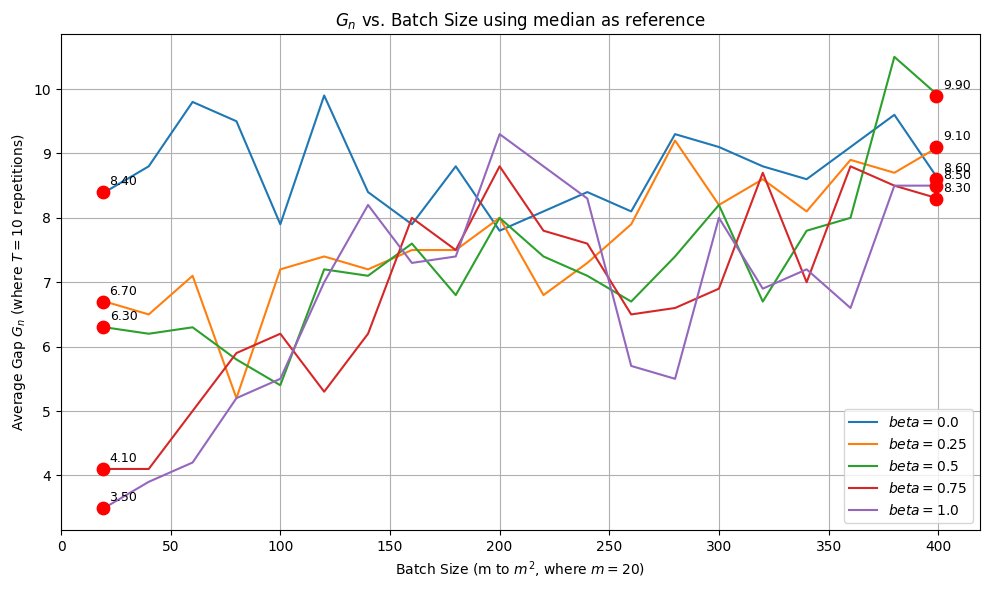

In [ ]:
bins = 20
repeat = 10
m = bins - 1
m2 = bins**2 - 1
avg_gap = [None] * 5
betas = [x for x in range(5)]
batches = [b for b in range(bins, m2 + 2, bins)]
highlight = [None] * 5
title = '$G_n$ vs. Batch Size using median as reference'
start = time.perf_counter()
for beta in betas:
  avg_gap[beta] = []
  for batch in batches:
    avg_gap[beta].append(execute_experiment(m2 + 1, bins, beta * 0.25, batch, repeat, partial_info=1))
  highlight[beta] = [[m, m2], [avg_gap[beta][0], avg_gap[beta][bins - 1]]]
end = time.perf_counter()
print(f'Experiment "{title}" execution took {end - start} seconds')
show_experiment(bins, batches, avg_gap, [beta * 0.25 for beta in betas], title, f'Batch Size (m to $m^2$, where $m={bins}$)', 'beta', highlight, repeat)

Experiment "$G_n$ vs. Number of Balls using median as reference" execution took 811.9003737590001 seconds


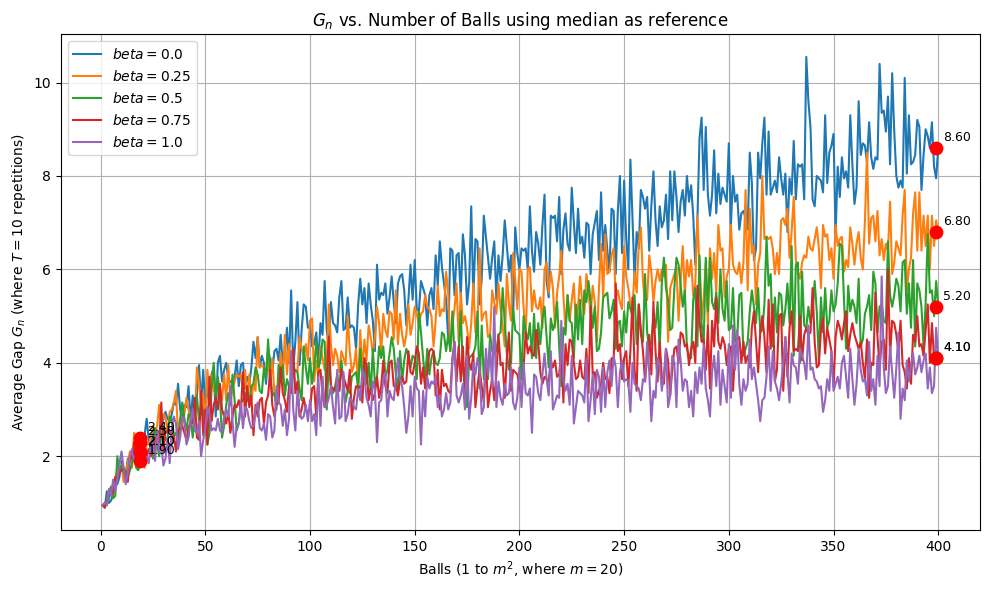

In [ ]:
bins = 20
repeat = 10
m = bins - 1
m2 = bins**2 - 1
avg_gap = [None] * 5
betas = [x for x in range(5)]
balls = np.arange(1, bins**2 + 1)
highlight = [None] * 5
title = '$G_n$ vs. Number of Balls using median as reference'


start = time.perf_counter()
for beta in betas:
  avg_gap[beta] = []
  for b in balls:
    avg_gap[beta].append(execute_experiment(b, bins, beta * 0.25, 1, repeat, partial_info=1))
  highlight[beta] = [[m, m2], [avg_gap[beta][m], avg_gap[beta][m2]]]
end = time.perf_counter()
print(f'Experiment "{title}" execution took {end - start} seconds')

show_experiment(bins, balls, avg_gap, [beta * 0.25 for beta in betas], title, f'Balls (1 to $m^2$, where $m={bins}$)', 'beta', highlight, repeat)


# Deciding allocation using partial information: using the median and then the 25% or 75% lowest as a reference

In [ ]:
bins = 20
repeat = 10
m = bins - 1
m2 = bins**2 - 1
avg_gap = [None] * 5
betas = [x for x in range(5)]
batches = [b for b in range(bins, m2 + 2, bins)]
highlight = [None] * 5
title = '$G_n$ vs. Batch Size using median and 25% or 75% lowest as reference'

start = time.perf_counter()
for beta in betas:
  avg_gap[beta] = []
  for batch in batches:
    avg_gap[beta].append(execute_experiment(m2 + 1, bins, beta * 0.25, batch, repeat, partial_info=2))
  highlight[beta] = [[m, m2], [avg_gap[beta][0], avg_gap[beta][bins - 1]]]
end = time.perf_counter()
print(f'Experiment "{title}" execution took {end - start} seconds')
show_experiment(bins, batches, avg_gap, [beta * 0.25 for beta in betas], title, f'Batch Size (m to $m^2$, where $m={bins}$)', 'beta', highlight, repeat)

Experiment "$G_n$ vs. Number of Balls using median and 25% or 75% lowest as reference" execution took 800.946166491 seconds


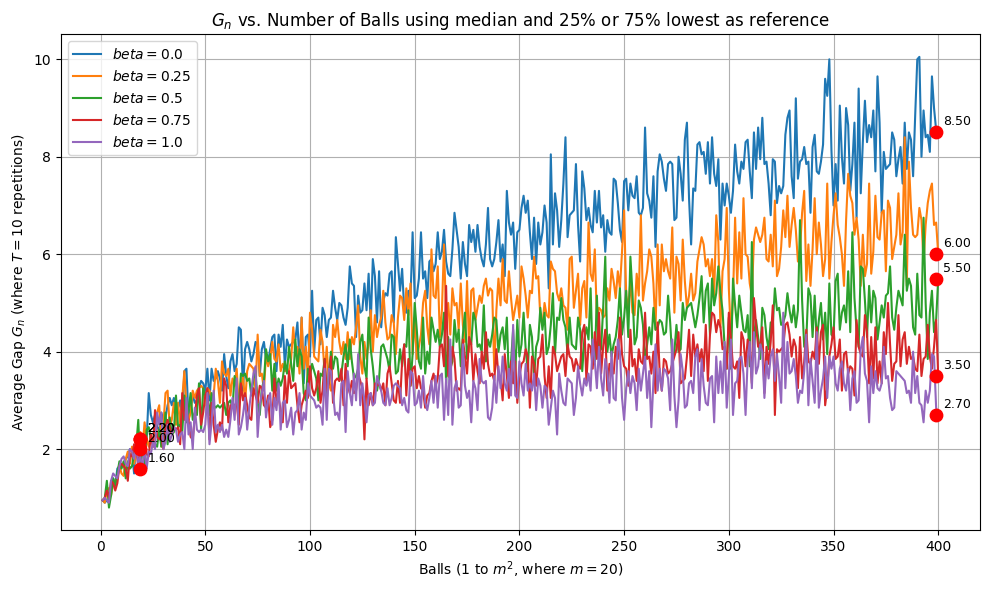

In [ ]:
bins = 20
repeat = 10
m = bins - 1
m2 = bins**2 - 1
avg_gap = [None] * 5
betas = [x for x in range(5)]
balls = np.arange(1, bins**2 + 1)
highlight = [None] * 5
title = '$G_n$ vs. Number of Balls using median and 25% or 75% lowest as reference'


start = time.perf_counter()
for beta in betas:
  avg_gap[beta] = []
  for b in balls:
    avg_gap[beta].append(execute_experiment(b, bins, beta * 0.25, 1, repeat, partial_info=2))
  highlight[beta] = [[m, m2], [avg_gap[beta][m], avg_gap[beta][m2]]]
end = time.perf_counter()
print(f'Experiment "{title}" execution took {end - start} seconds')

show_experiment(bins, balls, avg_gap, [beta * 0.25 for beta in betas], title, f'Balls (1 to $m^2$, where $m={bins}$)', 'beta', highlight, repeat)
